# Predict the Critical Temperature of a Superconductor with Random Forest
This notebook will reproduce and improve the Random Forest results of `predict_tc` in the Python language.

The paper makes these points about random forest implementation.

> We also tried random forests but they were too slow to tune given the data size and the number of features.

> Scalability and speed are important advantages of using XGBoost over random forests

In [1]:
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Local Modules
from pyplot_data import plot_observed_vs_predicted
from read_data import load_and_split

>**Out-Of_sample RMSE Estimation Procedure**
>1. At random divide the data into 2/3 train and 1/3 test data.

In [2]:
training_X, training_y, testing_X, testing_y = load_and_split(verbose=True)

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)
Training Size: 0.66 vs. Testing Size: 0.33999999999999997


>2. Fit the model using the train data.

The `main_script_production_9.R` (line 1563) uses the package `ranger` to implement random forests with number of trees set to `2500`.
>```R
>tmp_rf_model = ranger(critical_temp ~ ., data = train, num.trees = 2500)
>```

with the `mtry` argument set to 9 (line 1555)

>`Try a timing with but change num.trees to 2500, and default of mtry = 9`

> [`mtry`](https://www.rdocumentation.org/packages/ranger/versions/0.14.1/topics/ranger) - Number of variables to possibly split at in each node. Default is the (rounded down) square root of the number variables. Alternatively, a single argument function returning an integer, given the number of independent variables.

For `sklearn.ensemble.RandomForestRegressor` we will use the `min_samples_split` parameter.

>[`min_samples_split`: *int or float, default = 2*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) - The minimum number of samples required to split an internal node.

In [3]:
forest_mtry_9 = RandomForestRegressor(n_estimators=2500, min_samples_split=9)
forest_mtry_9.fit(training_X, training_y)

/tmp/ipykernel_1003/3351446048.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_mtry_9.fit(training_X, training_y)


RandomForestRegressor(min_samples_split=9, n_estimators=2500)

The paper also creates another model with `mtry` set to `50`.

In [4]:
forest_mtry_50 = RandomForestRegressor(n_estimators=2500, min_samples_split=50)
forest_mtry_50.fit(training_X, training_y)

/tmp/ipykernel_1003/372083894.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_mtry_50.fit(training_X, training_y)


RandomForestRegressor(min_samples_split=50, n_estimators=2500)

In [5]:
# Load Models
with open("../models/forest_mtry_9.pkl", "rb") as f:
    forest_mtry_9 = pickle.load(f)

with open("../models/forest_mtry_50.pkl", "rb") as f:
    forest_mtry_50 = pickle.load(f)

In [6]:
# Save Models
with open("../models/forest_mtry_9.pkl", "wb") as f:
    pickle.dump(forest_mtry_9, f)

with open("../models/forest_mtry_50.pkl", "wb") as f:
    pickle.dump(forest_mtry_50, f)

>3. Predict $T_c$ of the test data.

Score: 0.9550809457918821


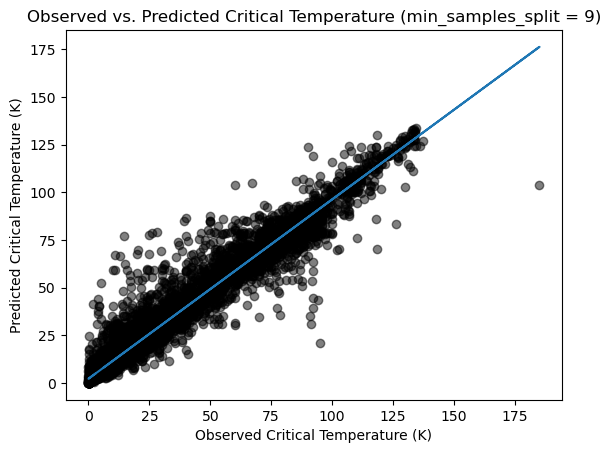

In [7]:
# Creates random forest predictions with testing features.
prediction_forest_mtry_9 = forest_mtry_9.predict(testing_X)

print(f"Score: {forest_mtry_9.score(testing_X, testing_y)}")

plot_observed_vs_predicted(
    testing_y,
    prediction_forest_mtry_9,
    title="Observed vs. Predicted Critical Temperature (min_samples_split = 9)"
)

Score: 0.9281769013577088


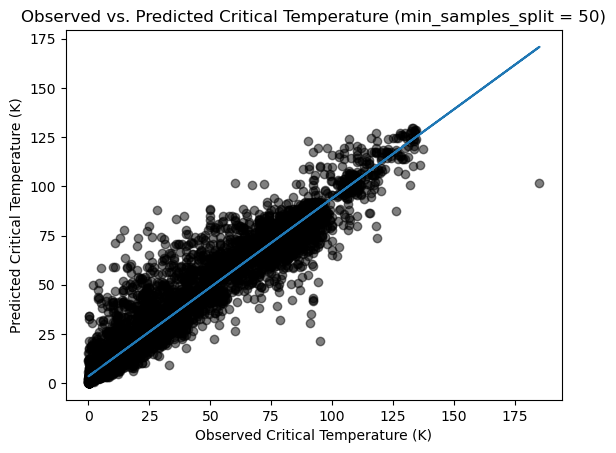

In [8]:
# Creates random forest predictions with testing features.
prediction_forest_mtry_50 = forest_mtry_50.predict(testing_X)

print(f"Score: {forest_mtry_50.score(testing_X, testing_y)}")

plot_observed_vs_predicted(
    testing_y,
    prediction_forest_mtry_50,
    title="Observed vs. Predicted Critical Temperature (min_samples_split = 50)"
)

> 4. Obtain an estimate of the out-of-sample mean-squared-error (mse) by using the predictions from the last step and the observed $T_c$ values in the test data:
>$$out\;of\;sample\;mse=Average\;of\;(observed-predicted)^2$$

In [9]:
mse_mtry_9 = mean_squared_error(testing_y, prediction_forest_mtry_9)
mse_mtry_50 = mean_squared_error(testing_y, prediction_forest_mtry_50)

print(f"Current MSE (mtry = 9): {mse_mtry_9}")
print(f"Current MSE (mtry = 50): {mse_mtry_50}")

Current MSE (mtry = 9): 52.26474400483564
Current MSE (mtry = 50): 83.56845286148094


> 5. Repeat steps 1 through 4, 25 times to collect 25 out-of-sample mse's.

In [10]:
mse_mtry_9_values = []
mse_mtry_50_values = []
for index in tqdm(range(25)):
    training_X, training_y, testing_X, testing_y = load_and_split(random_state=index)

    forest_mtry_9 = RandomForestRegressor(n_estimators=2500, min_samples_split=9)
    forest_mtry_9.fit(training_X, training_y)
    prediction_forest_mtry_9 = forest_mtry_9.predict(testing_X)
    mse_mtry_9_values.append(mean_squared_error(testing_y, prediction_forest_mtry_9))

    forest_mtry_50 = RandomForestRegressor(n_estimators=2500, min_samples_split=50)
    forest_mtry_50.fit(training_X, training_y)
    prediction_forest_mtry_50 = forest_mtry_50.predict(testing_X)
    mse_mtry_50_values.append(mean_squared_error(testing_y, prediction_forest_mtry_50))


  0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_1003/2255264787.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_mtry_9.fit(training_X, training_y)
/tmp/ipykernel_1003/2255264787.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_mtry_50.fit(training_X, training_y)
  4%|▍         | 1/25 [27:26<10:58:33, 1646.39s/it]/tmp/ipykernel_1003/2255264787.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_mtry_9.fit(training_X, training_y)
/tmp/ipykernel_1003/2255264787.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest

> 6. Take the mean of the 25 collected out-of-sample mse's and report the square root of this average as the final estimate of the out-of-sample-rmse.

In [12]:
print(f"Random Forest RMSE (mtry = 9): {np.sqrt(np.mean(mse_mtry_9_values))}")
print(f"Random Forest RMSE (mtry = 50): {np.sqrt(np.mean(mse_mtry_50_values))}")

Random Forest RMSE (mtry = 9): 9.749314169322375
Random Forest RMSE (mtry = 50): 10.636622908028864
